In [106]:
import numpy as np
import tensorflow as tf


from sklearn.preprocessing import normalize
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import math
import requests
from io import BytesIO


import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

In [3]:
from lucid.modelzoo.vision_base import Model

class DLA(Model):
    model_path = 'https://storage.googleapis.com/dla_protobuff/full_model_8_13.pb'
    image_shape = [1, 400]
    image_value_range = [0, 1]
    input_name = 'x'

In [119]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 50 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=267
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{210}}px; height: {{157}}px; background-position: -{{210*(act.n%sprite_n_wrap)}}px -{{157*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/200.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 2048px;
    }
    .input_image {
        display: inline-block;
        width: 400px;
        height: 267px;
    }
    .input_image .image, .input_image .pointer_container {
        position: absolute;
        width: 400px;
        height: 267px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: .1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[0]][0],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_vw0holng/SemanticDict_bfb2eea3_fd16_472c_a5b8_d8d5230b679d.html > /tmp/svelte_vw0holng/SemanticDict_bfb2eea3_fd16_472c_a5b8_d8d5230b679d.js
b'svelte version 1.64.1\ncompiling ../../../../../../tmp/svelte_vw0holng/SemanticDict_bfb2eea3_fd16_472c_a5b8_d8d5230b679d.html...\n'


In [5]:
LAYERS = { 'conv1': 'Conv2D',
           'conv1_relu':'Relu',
           'pool1': 'MaxPool',
           'conv2': 'Conv2D_1',
           'conv2_relu': 'Relu_1',
           'pool2': 'MaxPool_1',
           'conv3': 'Conv2D_2',
           'conv3_relu': 'Relu_2',
           'pool3': 'MaxPool_2',
           'fc1': 'MatMul',
           'fc1_relu': 'Relu_3'}


layer_spritemap_sizes = {
    'conv1': 10,
    'conv1_relu': 10, 
    'pool1': 10,
    'conv2': 12,
    'conv2_relu': 12,
    'pool2': 12,
    'conv3': 12,
    'conv3_relu': 12,
    'pool3': 12,
    'fc1': 25,
    'fc1_relu': 25}


def dla_spritemap(layer):
    assert layer in layer_spritemap_sizes
    size = layer_spritemap_sizes[layer]
    url = "https://storage.googleapis.com/dla_spritemaps/1d_spritemaps/%s.png" % layer
    return size, url

In [113]:
model = DLA()
model.load_graphdef()


def dla_semantic_dict(layer, test_input, img_file):
    model_layer = LAYERS[layer]
    
    input_1d = test_input # Actual 1-Dimensional test input
    img = load(img_file)
    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, shape=[1, 400, 1, 1])
        T = render.import_model(model, t_input, t_input)
        acts = T(model_layer).eval({t_input: input_1d})[0]
        
    
    # Find best position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    #print(max_x)
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = dla_spritemap(layer)
    
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 210,
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img),
        "activations": [[[{"n": float(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [float(max_x), 0]
    })
    return acts


In [78]:
def get_pos_activations(pos, activations):
    x = pos[0]
    y = pos[1]
    present_acts = activations[x][y]
    return present_acts

def get_sprite_dims(acts, spritemap_wrap, sprite_size):
    sprites = []
    for s in acts:
        n = s['n']
        v = s['v']
        x = int(n % spritemap_wrap) * 210
        y = math.floor(n/spritemap_wrap) * 157
        dim = [x, y]
        val = [dim, v]
        sprites.append(val)
    return sprites

def load_sprites(s_dims, sprite_size, img):
    sprites = []
    for i in range(4):
        value = s_dims[i][1]
        left = s_dims[i][0][0]
        upper = s_dims[i][0][1]
        right = left + 210
        lower = upper + 157
        crop_rectangle = (left, upper, right, lower)
        cropped_im = img.crop(crop_rectangle)
        val = cropped_im, value
        sprites.append(val)
    return sprites
        
def display_sprites(sprites):
    for i in range(len(sprites)):
        print(sprites[i][1])
        display(sprites[i][0])   
        
def best_four(layer, x, activations):
    acts = [[[{"n": float(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in activations]
    spritemap_n, spritemap_url = dla_spritemap(layer)
    sprite_size = 210
    spritemap_wrap = spritemap_n 
    
    response = requests.get(spritemap_url)
    img = Image.open(BytesIO(response.content))
    
    p_acts = get_pos_activations([x,0], acts)
    s_dims = get_sprite_dims(p_acts, spritemap_wrap, sprite_size)
    sprites = load_sprites(s_dims, sprite_size, img)
    display_sprites(sprites)

In [79]:
def resize_input(image_file):
    img = Image.open(image_file)
    img = img.resize((400,267), Image.ANTIALIAS)
    img.save(image_file)

In [80]:
def run(data, start, layer):
    flux = np.load(data)
    flux_test = flux[start:start+400]
    flux_test = flux_test.reshape(1, 400, 1, 1)
    flux_graph = flux_test.reshape(400)
    fig = plt.figure(frameon=False);
    ax = plt.Axes(fig, [0, 0, 1, 1]);
    ax.set_axis_off();
    fig.add_axes(ax);
    ax.plot(flux_graph, 'black');
    ax.set(xlim=(0, 400));
    file_save = 'flux_' + str(start) + '.png'
    fig.savefig(file_save);
    plt.close(fig)
    resize_input(file_save)
    acts = dla_semantic_dict(layer, flux_test, file_save)
    return acts
    


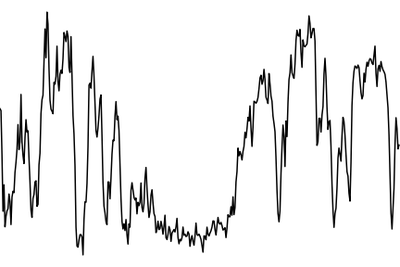

In [122]:
# DLA is present in this first image with atrt point 0
acts = run('../data/flux.npy', 0, 'conv1_relu')

In [85]:
best_four('conv1', 98, acts)

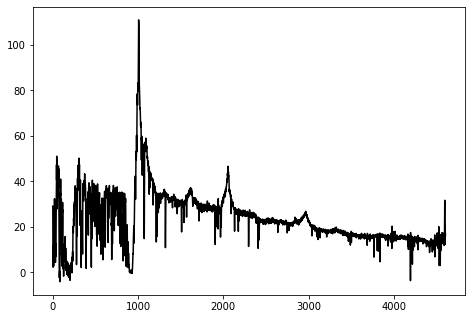

In [99]:
og = np.load('../data/flux.npy')
fig = plt.figure(frameon=False);
ax = plt.Axes(fig, [0, 0, 1, 1]);
#ax.set_axis_off();
fig.add_axes(ax);
ax.plot(og, 'black');
#ax.set(xlim=(0, 400));